# Explore Waves and Conditions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

In [2]:
rcParams["figure.figsize"] = (7, 7)

In [3]:
df = pd.read_csv("covid_victim.csv").assign(is_70_plus=lambda df: df["age"] >= 70)

In [4]:
cond_cols = df.columns[df.columns.str.startswith("condition")]

In [5]:
mean_cols = [
    "positive_rate",
    "total_vaccinations",
    "people_vaccinated",
    "people_fully_vaccinated",
    "total_boosters",
]
sum_cols = [*cond_cols, "is_70_plus", "is_male"]
aggs = {
    **{c: "sum" for c in sum_cols},
    **{c: "mean" for c in mean_cols},
    "count": "sum",
}

In [6]:
MIN_ASC = 30


def get_wave_n(df):
    wave_ascents = df.groupby("stage")["climb"].mean().loc[lambda s: s > 40].index
    _dic = {a: i + 1 for i, a in enumerate(wave_ascents)}
    wave_dic = {**_dic, **{k + 1: v for k, v in _dic.items()}}
    subseq_waves = pd.Series([wave_dic.get(e, 0) for e in df["stage"]], index=df.index)
    return np.where(
        df["climb"].abs().rolling(4).mean() > (MIN_ASC / 2), subseq_waves, 0
    ).astype(str)


weekly_wave_df = (
    df.assign(count=1, pdate=pd.to_datetime(df["estimated_date"]))
    .groupby("pdate")
    .agg(aggs)
    .resample("1W")
    .agg(aggs)
    .assign(
        climb=lambda df: df["count"].diff(),
        stage=lambda df: (df["climb"] > MIN_ASC)
        .diff()
        .pipe(lambda s: s & (s != s.shift(1)) & (s != s.shift(2)))
        .fillna(0)
        .astype(int)
        .cumsum(),
        wave=get_wave_n,
        wave_stage=lambda df: np.where(
            df.groupby("stage")["climb"].transform("mean") > 0, "ascent", "descent"
        ),
    )
    .loc[lambda df: df["wave"] != "0"]
)

In [7]:
plt.switch_backend('module://matplotlib_inline.backend_inline')

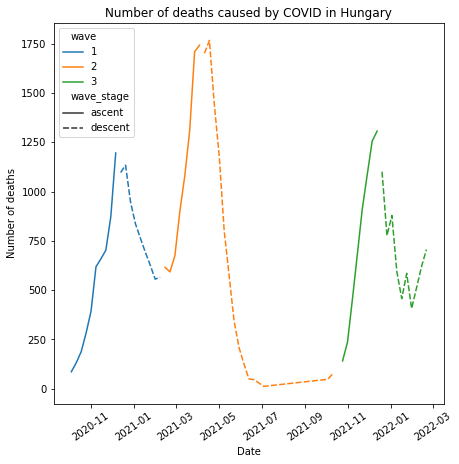

In [8]:
ax = weekly_wave_df.reset_index().pipe(
    lambda df: sns.lineplot(
        x="pdate", y="count", hue="wave", style="wave_stage", data=df
    )
)
plt.title("Number of deaths caused by COVID in Hungary")
plt.xlabel("Date")
plt.xticks(rotation = 35)
plt.ylabel("Number of deaths")
plt.show()

In [9]:
changes = (
    weekly_wave_df.loc[:, ["count", *sum_cols]]
    .pipe(lambda df: 2 * df.diff() / (df + df.shift()))
    .fillna(0)
    .pipe(lambda df: df - df[["count"]].values)
    .drop("count", axis=1)
)

In [10]:
(
    pd.concat([changes, weekly_wave_df[["wave", "wave_stage"]]], axis=1)
    .pivot_table(index=["wave", "wave_stage"], values=sum_cols)
    .rename(columns=lambda s: s.replace("condition__", ""))
    .style.background_gradient(
        axis=None,
        vmin=-0.1,
        vmax=0.1,
        cmap=sns.diverging_palette(
            220,
            20,
            as_cmap=True,
        ),
    )
    .set_caption("Growth of conditions compared to the growth of deceased people (%)")
)

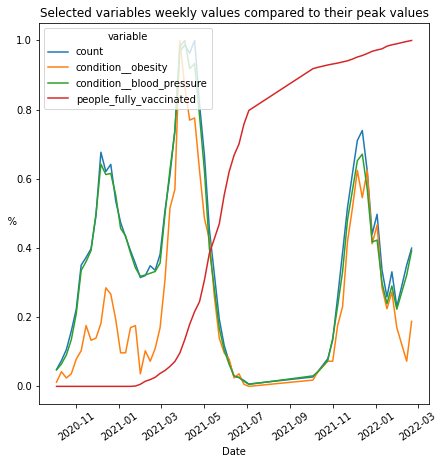

In [11]:
ax = weekly_wave_df.loc[
    :,
    [
        "count",
        "condition__obesity",
        "condition__blood_pressure",
        "people_fully_vaccinated",
    ],
].pipe(lambda df: df / df.max()).melt(ignore_index=False).reset_index().pipe(
    lambda df: sns.lineplot(x="pdate", y="value", hue="variable", data=df)
)

plt.title("Selected variables weekly values compared to their peak values")
plt.xlabel("Date")
plt.xticks(rotation = 35)
plt.ylabel("%", rotation = 180)
plt.show()

In [12]:
condition_counts = (
    pd.DataFrame(df["raw_conditions"].str.split(", ").tolist())
    .unstack()
    .dropna()
    .value_counts()
)

In [13]:
df_contition_counts = pd.DataFrame(condition_counts.head(20), columns = ['Count'])
df_contition_counts.index.name= 'Conditions'
df_contition_counts.style.set_caption("Top 20 conditions recorded for the deceased")

,Count
Conditions,
magasvérnyomás-betegség,20589
cukorbetegség,12811
magas vérnyomás,8891
iszkémiás szívbetegség,4860
szívbetegség,3614
demencia,3022
daganatos megbetegedés,2798
krónikus veseelégtelenség,2299
szívelégtelenség,2224
